<a href="https://colab.research.google.com/github/TimothyChenAllen/fema-experiments/blob/main/OpenFEMA_PA_Example_2024_03_29.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simple OpenFEMA Sample
This is an example of working with the OpenFEMA API to load data from its PA Project Details dataset, while respecting its 1000 record throttle. It takes advantage of PySpark to allow loading a large dataset, and will update the dataset as new records become available.

In [8]:
import requests
import pandas as pd
from IPython.display import clear_output

# Define the API endpoint
url = 'https://www.fema.gov/api/open/v1/PublicAssistanceFundedProjectsDetails'

# Set the parameters for the API request
params = {
    '$filter' : "declarationDate ge '2023-01-01T04:00:00.000z'",
    '$inlinecount' : 'allpages',
    '$select' : 'dcc,disasterNumber,declarationDate,incidentType,pwNumber,applicationTitle,applicantId,projectSize,county,countyCode,state,stateCode,stateNumberCode,projectAmount,federalShareObligated,totalObligated,obligatedDate',
    '$skip': 0
}

# Set the limit for records to fetch per request
limit=1000
all_records = []

# Loop to fetch data from the API
while True:
    clear_output(wait=True)
    response = requests.get(url, params=params)

    if response.status_code == 200:
        data = response.json()
        records = data.get('PublicAssistanceFundedProjectsDetails', [])
        expected_records = data.get('metadata')['count']
        all_records.extend(records)

        params['$skip'] += limit

        if len(records) < limit:
            break
        print(f"Received: {params['$skip']} of {expected_records}")
    else:
        print('Failed to retrieve data from the API')
        break

# Convert the list of records to a pandas DataFrame
combined_df = pd.DataFrame(all_records)
print(combined_df.shape)

(16482, 17)


In [9]:
from pyspark.sql import SparkSession

# Create a SparkSession
spark = SparkSession.builder.getOrCreate()

# Convert pandas DataFrame to Spark DataFrame
spark_df = spark.createDataFrame(combined_df)

# Check the schema of the Spark DataFrame
spark_df.printSchema()

root
 |-- dcc: string (nullable = true)
 |-- disasterNumber: long (nullable = true)
 |-- declarationDate: string (nullable = true)
 |-- incidentType: string (nullable = true)
 |-- pwNumber: long (nullable = true)
 |-- applicationTitle: string (nullable = true)
 |-- applicantId: string (nullable = true)
 |-- projectSize: string (nullable = true)
 |-- county: string (nullable = true)
 |-- countyCode: string (nullable = true)
 |-- state: string (nullable = true)
 |-- stateCode: string (nullable = true)
 |-- stateNumberCode: string (nullable = true)
 |-- projectAmount: double (nullable = true)
 |-- federalShareObligated: double (nullable = true)
 |-- totalObligated: double (nullable = true)
 |-- obligatedDate: string (nullable = true)



In [10]:
# Save Spark DataFrame as a Parquet file with overwrite mode
spark_df.write.mode('overwrite').parquet('output.parquet')

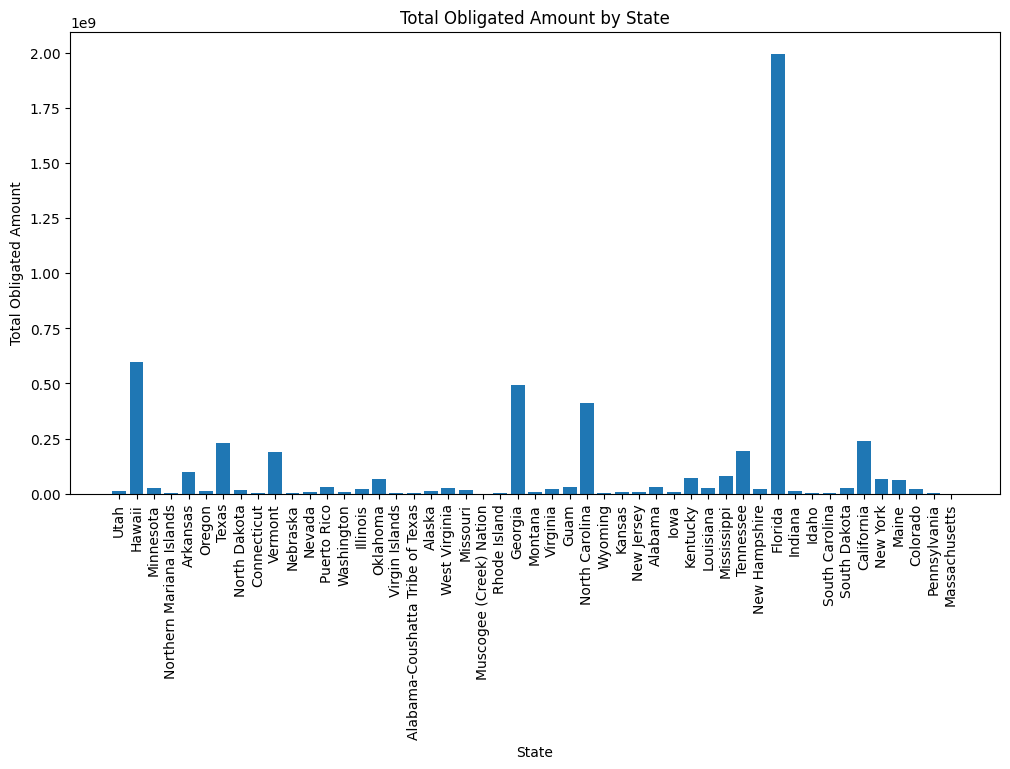

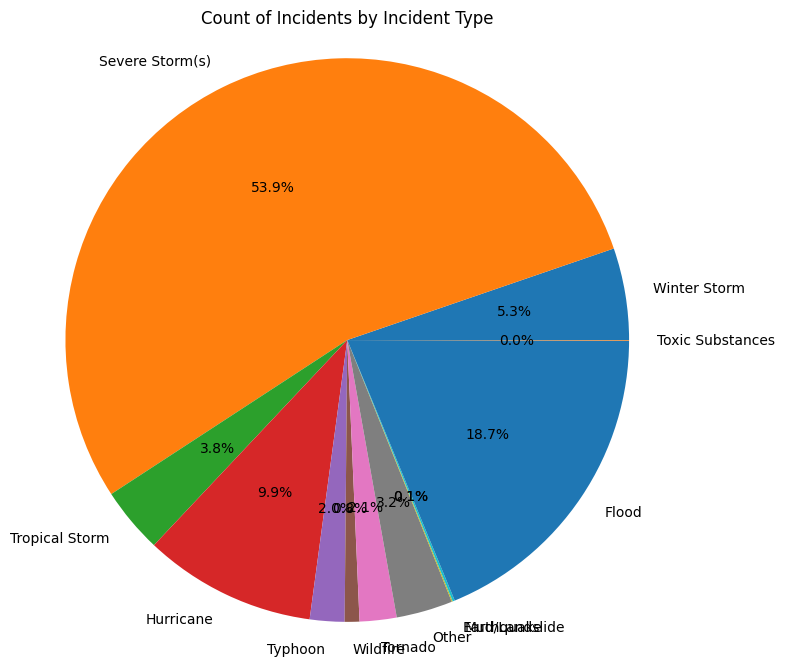

In [11]:
import matplotlib.pyplot as plt

# Calculate the total obligated amount by state
state_obligated_df = spark_df.groupby("state").sum("totalObligated")

# Convert the Spark DataFrame to a Pandas DataFrame
state_obligated_pd = state_obligated_df.toPandas()

# Plot a bar chart of the total obligated amount by state
plt.figure(figsize=(12, 6))
plt.bar(state_obligated_pd["state"], state_obligated_pd["sum(totalObligated)"])
plt.xlabel("State")
plt.ylabel("Total Obligated Amount")
plt.title("Total Obligated Amount by State")
plt.xticks(rotation=90)
plt.show()

# Calculate the count of incidents by incident type
incident_type_count_df = spark_df.groupby("incidentType").count()

# Convert the Spark DataFrame to a Pandas DataFrame
incident_type_count_pd = incident_type_count_df.toPandas()

# Plot a pie chart of the count of incidents by incident type
plt.figure(figsize=(8, 8))
plt.pie(incident_type_count_pd["count"], labels=incident_type_count_pd["incidentType"], autopct='%1.1f%%')
plt.title("Count of Incidents by Incident Type")
plt.axis("equal")
plt.show()

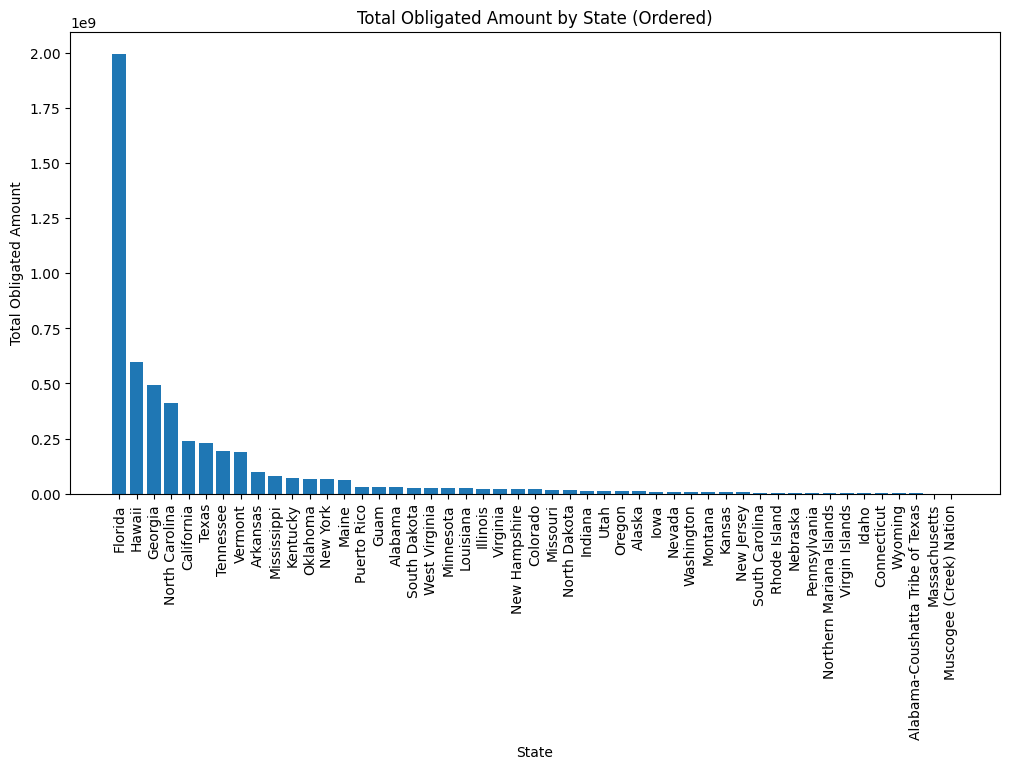

In [12]:
# Sort the total obligated amount by state in descending order
state_obligated_pd = state_obligated_pd.sort_values('sum(totalObligated)', ascending=False)

# Plot an ordered bar chart of the total obligated amount by state
plt.figure(figsize=(12, 6))
plt.bar(state_obligated_pd["state"], state_obligated_pd["sum(totalObligated)"])
plt.xlabel("State")
plt.ylabel("Total Obligated Amount")
plt.title("Total Obligated Amount by State (Ordered)")
plt.xticks(rotation=90)
plt.show()

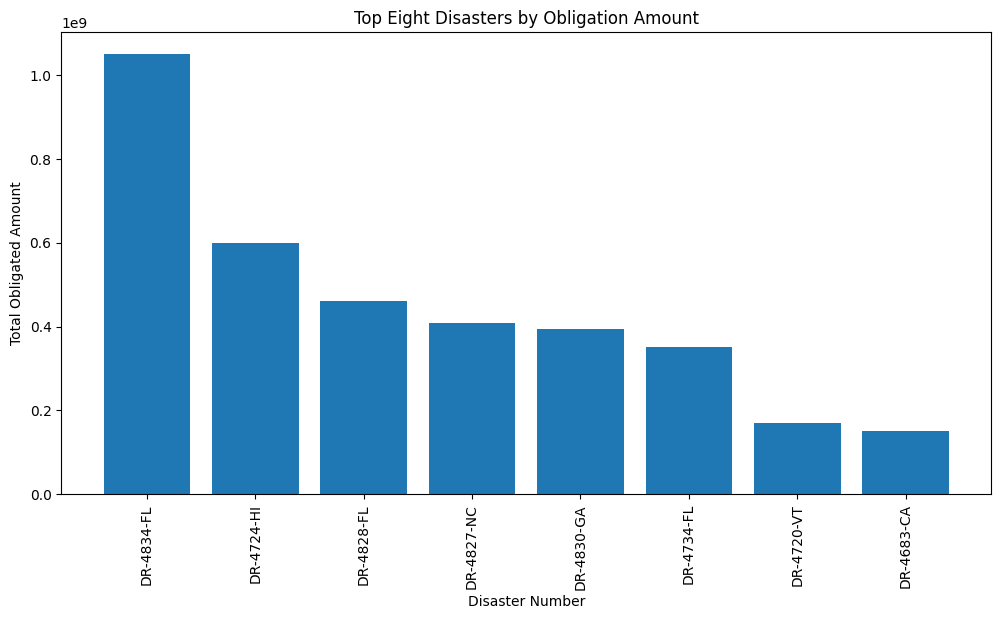

In [13]:
from pyspark.sql.functions import concat, lit

# Sort the total obligated amount by disaster in descending order
disaster_obligated_df = spark_df.groupby("disasterNumber","stateCode").sum("totalObligated")
disaster_obligated_df = disaster_obligated_df.orderBy('sum(totalObligated)', ascending=False)

# Add a new column with disasterNumber prefixed by "DR-" and suffixed with the state code
disaster_obligated_df = disaster_obligated_df.withColumn(
    "disasterNumber",
    concat(lit("DR-"), disaster_obligated_df["disasterNumber"], lit("-"), disaster_obligated_df["stateCode"])
)

# Convert the disasterNumber column to a string
disaster_obligated_df = disaster_obligated_df.withColumn("disasterNumber", disaster_obligated_df["disasterNumber"].cast("string"))

# Select the top eight disasters by obligation amount
top_eight_disasters = disaster_obligated_df.limit(8)

# Convert the Spark DataFrame to a Pandas DataFrame
top_eight_disasters_pd = top_eight_disasters.toPandas()

# Plot an ordered bar chart of the top eight disasters by obligation amount
plt.figure(figsize=(12, 6))
plt.bar(top_eight_disasters_pd["disasterNumber"], top_eight_disasters_pd["sum(totalObligated)"])
plt.xlabel("Disaster Number")
plt.ylabel("Total Obligated Amount")
plt.title("Top Eight Disasters by Obligation Amount")
plt.xticks(rotation=90)
plt.show()